In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.datasets import mnist # type: ignore

In [23]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
optical_recognition_of_handwritten_digits = fetch_ucirepo(id=80) 
  
# data (as pandas dataframes) 
X = optical_recognition_of_handwritten_digits.data.features.to_numpy()
y = optical_recognition_of_handwritten_digits.data.targets.to_numpy() 


In [24]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the data to fit the model
X_train = X_train.reshape(-1, 8, 8, 1)
X_test = X_test.reshape(-1, 8, 8, 1)

# Convert y to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Normalization data for CNN
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X_train.reshape(-1, 64))  # Reshape for MinMaxScaler
X_train = X_normalized.reshape(-1, 8, 8, 1)

In [25]:
def relu(x):
    return np.maximum(0, x)

class Conv3x3:
    '''
        A Convolution layer using 3x3 filters.
    '''

    def __init__(self, num_filters, filter_size, input_depth):
        self.num_filters = num_filters
        self.filter_size = filter_size
        self.filters = np.random.randn(num_filters, filter_size, filter_size, input_depth) * np.sqrt(2/(filter_size*filter_size*input_depth))

    def iterate_regions(self, image):
        '''
        Generates all possible 3x3 image regions using valid padding.
        - image is a 2d or 3d numpy array.
        '''
        h, w, _ = image.shape

        for i in range(h - 2):
            for j in range(w - 2):
                im_region = image[i:(i + 3), j:(j + 3)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the conv layer using the given input.
        Returns a 3d numpy array with dimensions (h, w, num_filters).
        - input is a 2d or 3d numpy array
        '''
        self.last_input = input

        h, w, _ = input.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))

        for im_region, i, j in self.iterate_regions(input):
            for f in range(self.num_filters):
                output[i, j, f] = relu(np.sum(im_region * self.filters[f, :, :, :]))  # ReLU activation

        return output
    
    def backprop(self, d_L_d_out, learn_rate):
        d_L_d_filters = np.zeros(self.filters.shape)

        # When we apply the conv operator forward, every (i, j) position in the output image was computed by
        # a dot product of the filter and a region of the input image. The gradient of the loss with respect to
        # the output image has the same shape as the output image. So, we can use the same regions of the input
        # image to compute the gradient with respect to the filters.
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

        # Update filters
        self.filters -= learn_rate * d_L_d_filters

        # Compute gradient with respect to input
        d_L_d_input = np.zeros(self.last_input.shape)
        for im_region, i, j in self.iterate_regions(d_L_d_out):
            for f in range(self.num_filters):
                d_L_d_input[i:i+3, j:j+3] += self.filters[f, :, :] * im_region[..., f, None]

        return d_L_d_input

In [26]:
class MaxPool2:
    '''
      A Max Pooling layer using a pool size of 2
    '''

    def iterate_regions(self, image):
        '''
        Generates non-overlapping 2x2 image regions to pool over.
        - image is a 2d numpy array
        '''
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        '''
        Performs a forward pass of the maxpool layer using the given input.
        Returns a 3d numpy array with dimensions (h / 2, w / 2, num_filters).
        - input is a 3d numpy array with dimensions (h, w, num_filters)
        '''
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.amax(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        # Compute gradient with respect to input
        d_L_d_input = np.zeros(self.last_input.shape)
        for im_region, i, j in self.iterate_regions(d_L_d_out):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if self.last_input[i+i2, j+j2, f2] == amax[f2]:
                            d_L_d_input[i+i2, j+j2, f2] = d_L_d_out[i, j, f2]

        return d_L_d_input

In [27]:
class Softmax:
    '''
        A standard fully-connected layer with softmax activation.
    '''

    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes) * np.sqrt(2/input_len)
        self.biases = np.zeros(nodes)

    def forward(self, input):
        '''
        Performs a forward pass of the softmax layer using the given input.
        Returns a 1d numpy array containing the respective probability values.
        - input can be any array with any dimensions.
        '''
        self.last_input_shape = input.shape

        # Flatten the input array
        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape

        # Calculate the weighted sum of inputs and biases
        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        # Apply the softmax activation function to get the probabilities
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)

    def backprop(self, d_L_d_out, learn_rate):
        '''
        Performs a backward pass of the softmax layer.
        Returns the loss gradient for this layer's inputs.
        - d_L_d_out is the loss gradient for this layer's outputs.
        - learn_rate is a float.
        '''
        # We know only 1 element of d_L_d_out will be nonzero
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue

            # Calculate the exponential of the last totals
            t_exp = np.exp(self.last_totals)

            # Calculate the sum of all exponentials
            S = np.sum(t_exp)

            # Calculate the gradients of out[i] against totals
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

            # Calculate the gradients of totals against weights/biases/input
            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            # Calculate the gradients of loss against totals
            d_L_d_t = gradient * d_out_d_t

            # Calculate the gradients of loss against weights/biases/input
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t

            # Update weights/biases using gradient descent
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b

        return d_L_d_inputs.reshape(self.last_input_shape)

In [28]:
def forward(image, label):
    # Ensure the image has three dimensions
    if len(image.shape) > 3:
        image = np.squeeze(image, axis=0)
        
    out = conv1.forward((image / 255) - 0.5)
    out = conv2.forward(out)
    out = conv3.forward(out)
    out = pool.forward(out)
    out = softmax.forward(out)
    
    # Convert one-hot encoded label to integer
    label_int = np.argmax(label)
    
    loss = -np.log(out[label_int])
    acc = 1 if np.argmax(out) == label_int else 0
    return out, loss, acc

def train(im, label, lr=.001):
    out, loss, acc = forward(im, label)
    gradient = np.zeros(10)
    
    # Convert one-hot encoded label to integer
    label_int = np.argmax(label)
    
    gradient[label_int] = -1 / out[label_int]
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv3.backprop(gradient, lr)
    gradient = conv2.backprop(gradient, lr)
    gradient = conv1.backprop(gradient, lr)
    return loss, acc

In [29]:
# 8x8x1 -> 6x6x8
conv1 = Conv3x3(8, 3, 1)  # First conv layer, input depth is 1

# 6x6x8 -> 4x4x16
conv2 = Conv3x3(16, 3, 8)  # Second conv layer, input depth is 8 (output of conv1)

# 4x4x16 -> 2x2x32
conv3 = Conv3x3(32, 3, 16)  # Third conv layer, input depth is 16 (output of conv2)

# 2x2x32 -> 1x1x32
pool = MaxPool2()

# 1x1x32 -> 10
softmax = Softmax(1 * 1 * 32, 10)

In [30]:
from tqdm import tqdm

# Initialize lists to store accuracies
train_accuracies = []
test_accuracies = []

for epoch in range(10):
    print('--- Epoch %d ---' % (epoch + 1))

    # Shuffle the training data
    X_train, y_train = shuffle(X_train, y_train)

    # Initialize variables for loss and accuracy calculation
    train_loss = 0
    train_correct = 0

    # Iterate over each training sample
    for i, (im, label) in tqdm(enumerate(zip(X_train, y_train)), total=len(X_train), desc="Training"):
        # Perform a training step on the current sample
        l, acc = train(im, label)
        train_loss += l
        train_correct += acc

    # Calculate and print training accuracy and loss after each epoch
    avg_train_loss = train_loss / len(X_train)
    train_accuracy = train_correct / len(X_train)
    print('Train Loss: {:.3f} | Train Accuracy: {:2.2f}%'.format(avg_train_loss, train_accuracy * 100))
    train_accuracies.append(train_accuracy)


    # Initialize variables for test accuracy calculation
    test_correct = 0

    # Iterate over each test sample
    for i, (im, label) in tqdm(enumerate(zip(X_test, y_test)), total=len(X_test), desc="Testing"):
        # Perform a forward pass on the current sample
        out, _, acc = forward(im, label)
        test_correct += acc

    # Calculate and print test accuracy after each epoch
    test_accuracy = test_correct / len(X_test)
    print('Test Accuracy: {:2.2f}%'.format(test_accuracy * 100))
    test_accuracies.append(test_accuracy)


--- Epoch 1 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 143.68it/s]


Train Loss: 2.350 | Train Accuracy: 9.45%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 234.84it/s]


Test Accuracy: 10.59%
--- Epoch 2 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 143.12it/s]


Train Loss: 2.306 | Train Accuracy: 10.21%


Testing: 100%|██████████| 1124/1124 [00:05<00:00, 223.90it/s]


Test Accuracy: 8.90%
--- Epoch 3 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 142.71it/s]


Train Loss: 2.306 | Train Accuracy: 9.45%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 233.29it/s]


Test Accuracy: 10.05%
--- Epoch 4 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 143.17it/s]


Train Loss: 2.305 | Train Accuracy: 9.81%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 238.13it/s]


Test Accuracy: 7.03%
--- Epoch 5 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 143.36it/s]


Train Loss: 2.306 | Train Accuracy: 9.74%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 236.45it/s]


Test Accuracy: 10.23%
--- Epoch 6 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 144.16it/s]


Train Loss: 2.306 | Train Accuracy: 9.03%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 236.28it/s]


Test Accuracy: 6.76%
--- Epoch 7 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 142.46it/s]


Train Loss: 2.306 | Train Accuracy: 8.96%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 226.92it/s]


Test Accuracy: 6.67%
--- Epoch 8 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 144.43it/s]


Train Loss: 2.306 | Train Accuracy: 9.23%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 233.65it/s]


Test Accuracy: 10.94%
--- Epoch 9 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 143.32it/s]


Train Loss: 2.305 | Train Accuracy: 9.27%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 235.26it/s]


Test Accuracy: 8.45%
--- Epoch 10 ---


Training: 100%|██████████| 4496/4496 [00:31<00:00, 142.72it/s]


Train Loss: 2.305 | Train Accuracy: 9.85%


Testing: 100%|██████████| 1124/1124 [00:04<00:00, 230.11it/s]

Test Accuracy: 9.88%


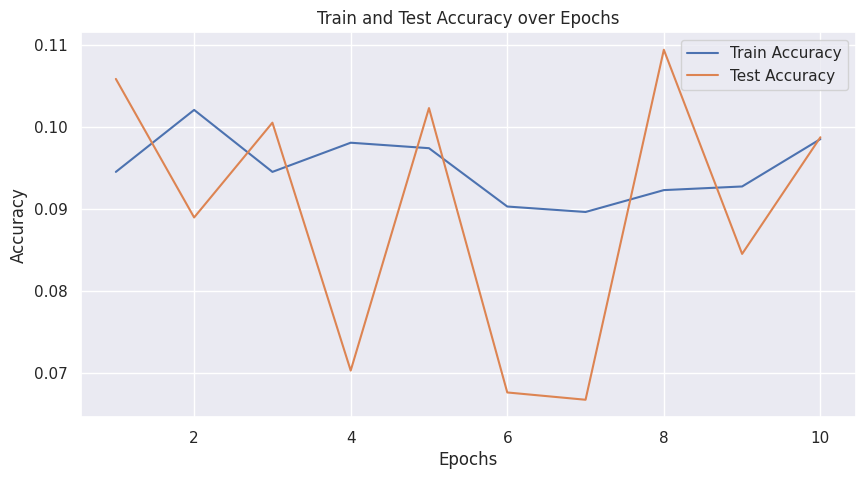

In [33]:
import matplotlib.pyplot as plt

# Plot the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.title('Train and Test Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Print a message indicating the start of testing the CNN
print('--- Testing the CNN ---')

# Initialize variables for loss and accuracy calculation
loss = 0
num_correct = 0

# Iterate over each test sample
for im, label in zip(X_test, y_test):
    # Perform a forward pass of the CNN and calculate the loss and accuracy
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

# Calculate the average test loss and accuracy
num_tests = len(X_test)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

--- Testing the CNN ---
Test Loss: 2.310081223006229
Test Accuracy: 0.09875444839857651


Classification Report:

               precision    recall  f1-score   support

           0       0.00      0.00      0.00       108
           1       0.00      0.00      0.00       102
           2       0.00      0.00      0.00       107
           3       0.00      0.00      0.00       118
           4       0.00      0.00      0.00       117
           5       0.06      0.03      0.04        97
           6       0.00      0.00      0.00       123
           7       0.10      0.87      0.18       124
           8       0.00      0.00      0.00       105
           9       0.00      0.00      0.00       123

    accuracy                           0.10      1124
   macro avg       0.02      0.09      0.02      1124
weighted avg       0.02      0.10      0.02      1124



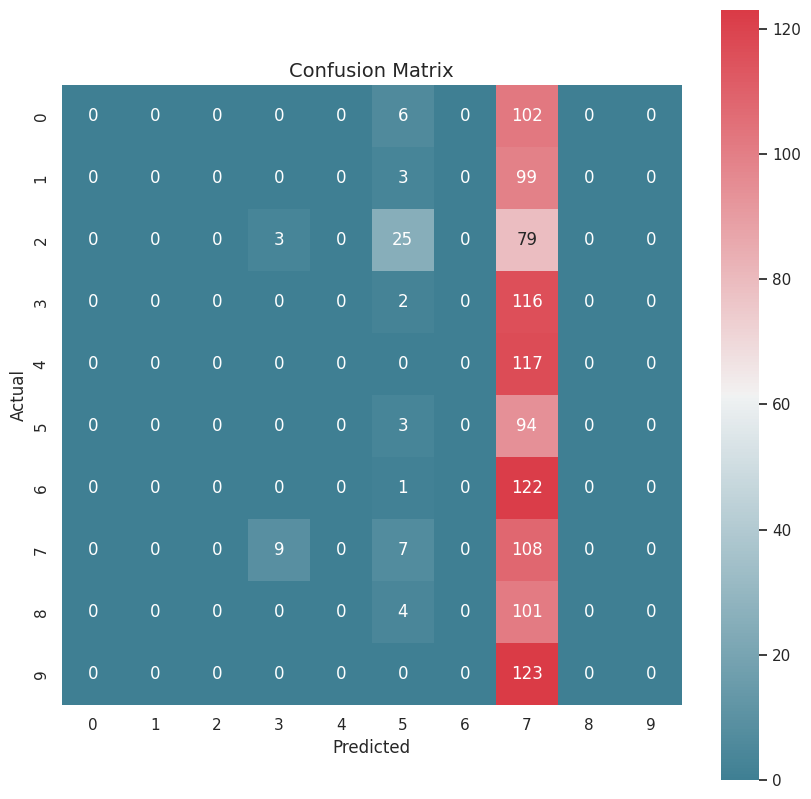

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
y_pred = []
for im in X_test:
    out, _, _ = forward(im, label=None)
    pred_label = np.argmax(out)
    y_pred.append(pred_label)

y_test = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test, y_pred, zero_division=0)

# Print classification report
print("Classification Report:\n\n", report)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a color map for the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Define color map
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap=cmap, annot=True, fmt="g", square=True)

# Set labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

